## ***Responsible AI - 2024***
### *Proyecto #1*

Stefano Aragoni, Carol Arévalo, José Miguel González, Luis Santos

--------------------

Este proyecto se centra en la aplicación y el estudio de métodos de interpretación modelo-agnósticos, con un enfoque específico en SHAP (SHapley Additive exPlanations), para analizar y explicar las predicciones de churn de clientes en el sector de telecomunicaciones. Utilizando un dataset de churn de clientes de una compañía de telecomunicaciones disponible en Kaggle, el proyecto implementará modelos de predicción de churn, como árboles de decisión y Random Forest, y aplicará SHAP para desentrañar la influencia de diversas características en las predicciones del modelo.

### Objetivo del Proyecto

El objetivo principal de este proyecto es demostrar cómo los métodos de interpretación modelo-agnósticos pueden ser utilizados para proporcionar insights claros y comprensibles sobre las predicciones de modelos complejos de machine learning, específicamente en el contexto de la predicción de churn de clientes. Al hacerlo, el proyecto busca:

1. **Implementar y evaluar modelos predictivos** para la predicción de churn utilizando técnicas de machine learning como árboles de decisión y Random Forest.

2. **Aplicar SHAP**, un método de interpretación modelo-agnóstico, para analizar cómo diferentes características contribuyen a las predicciones de churn, permitiendo una interpretación detallada y justificable de los resultados del modelo.

3. **Visualizar y comunicar la importancia y el efecto de las características** en las decisiones del modelo, usando las visualizaciones proporcionadas por SHAP, como los plots de fuerza, de dependencia, y los summary plots.

4. **Facilitar la toma de decisiones basadas en datos** en el sector de telecomunicaciones, ayudando a identificar factores clave que influyen en el churn de clientes y posibles áreas de intervención para mejorar la retención de clientes.

Este enfoque no solo aumenta la transparencia de los modelos predictivos utilizados sino que también mejora la confianza de los stakeholders al proporcionar una comprensión clara de por qué ciertos clientes son más propensos a abandonar los servicios, apoyando así la creación de estrategias de retención más efectivas basadas en datos concretos y análisis robusto.

-------

#### *1. Setup*

Primero se importan las librerías necesarias para el desarrollo del proyecto. Asimismo, se realiza la configuración inicial requerida para el análisis. 

In [68]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para preprocesamiento / limpieza de datos
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Librerías para modelado
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# SHAP
import shap

# Configuraciones adicionales
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Lectura de dataset
df = pd.read_csv('./dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [70]:
# Limpieza de Datos (Inicial)

# Corrección del tipo de dato en columna 'TotalCharges'
    # Esta columna tiene valores numéricos. Sin embargo, Pandas la reconoce como object. Por lo tanto, se convierte a numérica.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Convertir 'SeniorCitizen' a categórica
    # La columna 'SeniorCitizen' es numérica (0/1), pero en realidad es categórica (Yes/No). Por lo tanto, se convierte a categórica para que haya consistencia.
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

-------

#### *2. Exploratory Data Analysis (EDA)*

Se busca realizar un análisis exploratorio de los datos para comprender la estructura y las características del dataset. Esto incluye la identificación de las variables, verificación de valores faltantes, análisis gráfico de datos, entre otros. 

##### *2.1. Descripción de Columnas*

El primer paso en el análisis exploratorio de datos es comprender la estructura del dataset y las variables que contiene. 

- Se utiliza la función de pandas `info()` para obtener información sobre las columnas y los tipos de datos presentes en el dataset. 

- Se utiliza la función `head()` para visualizar las primeras filas del dataset y tener una idea de cómo están estructurados los datos.

- Se utiliza la función `describe()` para obtener estadísticas descriptivas de las variables presentes en el dataset.


La función `info()`, como se puede observar, indica que hay 7,043 registros en el dataset y 21 columnas. Además, se puede ver que hay variables categóricas (object) y numéricas (int64 y float64) presentes en el dataset.

In [71]:
# Información general del dataset (columnas, valores nulos, tipo de datos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


La función `head()` permite visualizar las primeras filas del dataset. Como se puede observar, hay varias columnas que contienen información sobre los clientes, como el género, la edad, el estado civil, la educación, entre otros. Además, hay columnas que contienen información sobre los servicios contratados por los clientes. Finalmente, la columna **Churn** indica si el cliente ha abandonado o no los servicios de la compañía.

Con base a la información proporcionada por el dataset, se identificaron las siguientes columnas:

- **customerID**: Identificador único de cada cliente.  

- **gender**: Género del cliente. (Male/Female)

- **SeniorCitizen**: Indica si el cliente es una persona mayor. (Yes/No) 

- **Partner**: Indica si el cliente tiene pareja. (Yes/No)

- **Dependents**: Indica si el cliente tiene dependientes. (Yes/No)

- **tenure**: Número de meses que el cliente ha estado con la empresa.  

- **PhoneService**: Indica si el cliente tiene servicio telefónico. (Yes/No)

- **MultipleLines**: Indica si el cliente tiene múltiples líneas telefónicas. (Yes/No/No phone service)

- **InternetService**: Tipo de servicio de internet que el cliente tiene. (DSL/Fiber optic/No)

- **OnlineSecurity**: Indica si el cliente tiene servicio de seguridad en línea. (Yes/No)

- **OnlineBackup**: Indica si el cliente tiene servicio de respaldo en línea. (Yes/No)

- **DeviceProtection**: Indica si el cliente tiene protección de dispositivos. (Yes/No)

- **TechSupport**: Indica si el cliente tiene soporte técnico. (Yes/No)

- **StreamingTV**: Indica si el cliente tiene servicio de transmisión de TV. (Yes/No)

- **StreamingMovies**: Indica si el cliente tiene servicio de transmisión de películas. (Yes/No)

- **Contract**: Tipo de contrato del cliente. (Month-to-month/One year/Two year)

- **PaperlessBilling**: Indica si el cliente utiliza facturación electrónica. (Yes/No)

- **PaymentMethod**: Método de pago utilizado por el cliente. (Electronic check/Mailed check/Bank transfer (automatic)/Credit card (automatic))

- **MonthlyCharges**: Cantidad mensual que el cliente paga por los servicios.  

- **TotalCharges**: Cantidad total que el cliente ha pagado por los servicios desde que se unió.  

- **Churn**: Indica si el cliente ha dejado de utilizar los servicios. (Yes/No) (VARIABLE OBJETIVO)

In [72]:
# Visualización de los primeros registros
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Posteriormente, se utiliza la función `describe()` para obtener estadísticas descriptivas de las variables numéricas presentes en el dataset.

En este caso, el dataset original contiene 3 variables numéricas: **tenure**, **MonthlyCharges** y **TotalCharges**.

- **tenure**: Esta variable representa el número de meses que el cliente ha estado con la empresa. La media de esta variable es 32.4 meses, con un mínimo de 0 meses y un máximo de 72 meses.

- **MonthlyCharges**: Esta variable representa la cantidad mensual que el cliente paga por los servicios. La media de esta variable es 64.8, con un mínimo de 18.25 y un máximo de 118.75.

- **TotalCharges**: Esta variable representa la cantidad total que el cliente ha pagado por los servicios desde que se unió. La media de esta variable es 2283.3, con un mínimo de 18.8 y un máximo de 8684.8.

In [73]:
# Descripción de columnas numéricas
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


El procedimiento anterior se repitió pero para las variables categóricas presentes en el dataset.

A través de este análisis, se obtuvo una visión general de las variables presentes en el dataset y se identificaron las características clave. Por ejemplo:

- La mayoría de los clientes son personas hombres (3,555)
- La mayoría de los clientes no son personas mayores (5,901)
- La mayoría de los clientes no tienen dependientes (4,933)
- Una gran proporción de clientes tiene servicio telefónico (6,361)
- La mayoría de los clientes no son CHURN (5,174)

In [74]:
# Descripción de columnas categóricas
df.describe(include='object')

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


##### *2.2. Verificación de Datos Faltantes/Nulos*

El siguiente paso en el análisis exploratorio de datos es verificar si hay nulos o faltantes en el dataset.

Como se puede observar a continuación, la columna **TotalCharges** tiene 11 valores nulos.

In [75]:
# Análisis de valores nulos
print('Valores nulos por columna:')             # Se imprime el mensaje
print(df.isnull().sum())                        # Se cuentan los valores nulos por columna

Valores nulos por columna:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


##### *2.3. Análisis Gráfico de los Datos*

El tercer paso en el análisis exploratorio de datos es realizar un análisis gráfico de los datos para visualizar la distribución de las variables y las relaciones entre ellas.

In [76]:
# Funciones para graficar datos

# ------ Plot de Distribución ------
# Descripción: Función para graficar la distribución de una columna numérica
# Parámetros:
# - data: DataFrame
# - col: str, nombre de la columna
# - hue: str, nombre de la columna para diferenciar por color
# Return: None
def plot_distribution(data, col, hue=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))                               # Se crea una figura con 2 subplots

    # Plot 1
    sns.histplot(data, x=col, kde=False, multiple='stack', ax=ax[0])            # Se grafica la distribución de la columna
    ax[0].set_title(f'Distribución de {col}')                                   # Se agrega el título           
    ax[0].set_xlabel(col)                                                       # Se agrega la etiqueta del eje x
    ax[0].set_ylabel('Frecuencia')                                              # Se agrega la etiqueta del eje y

    # Plot 2
    sns.histplot(data, x=col, hue=hue, kde=False, multiple='stack', ax=ax[1])   # Se grafica la distribución de la columna por categoría
    ax[1].set_title(f'Distribución de {col} por {hue}')                         # Se agrega el título
    ax[1].set_xlabel(col)                                                       # Se agrega la etiqueta del eje x
    ax[1].set_ylabel('Frecuencia')                                              # Se agrega la etiqueta del eje y

    plt.show()                                                                  # Se muestra la figura

# ------ Plot de Conteo de Categorías ------
# Descripción: Función para graficar el conteo de categorías en una columna
# Parámetros:
# - data: DataFrame
# - col: str, nombre de la columna
# - hue: str, nombre de la columna para diferenciar por color
# Return: None
def plot_category_count(data, col, hue=None):                           

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))                               # Se crea una figura con 2 subplots

    # Plot 1
    sns.countplot(data=data, x=col, ax=ax[0])                                   # Se grafica el conteo de categorías en la columna
    ax[0].set_title(f'Conteo de {col}')                                         # Se agrega el título
    ax[0].set_xlabel(col)                                                       # Se agrega la etiqueta del eje x
    ax[0].set_ylabel('Frecuencia')                                              # Se agrega la etiqueta del eje y

    for p in ax[0].patches:                                                     # Se itera sobre las barras para agregar el valor de cada categoría
        ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center', xytext=(0, 0), textcoords='offset points')

    # Plot 2
    sns.countplot(data=data, x=col, hue=hue, ax=ax[1])                          # Se grafica el conteo de categorías en la columna por categoría
    ax[1].set_title(f'Conteo de {col} por {hue}')                               # Se agrega el título
    ax[1].set_xlabel(col)                                                       # Se agrega la etiqueta del eje x
    ax[1].set_ylabel('Frecuencia')                                              # Se agrega la etiqueta del eje y

    for p in ax[1].patches:                                                     # Se itera sobre las barras para agregar el valor de cada categoría
        ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center', xytext=(0, 0), textcoords='offset points')

    plt.show()                                                                  # Se muestra la figura


# ------ Multi-Plot de Conteo de Categorías ------
# Descripción: Función para graficar el conteo de categorías de múltiples columnas
# Parámetros:
# - data: DataFrame
# - cols: list, lista de nombres de columnas
# - hue: str, nombre de la columna para diferenciar por color
# Return: None
def plot_multi_category_count(data, cols, hue=None):

    n_cols = len(cols)                                                          # Se obtiene la cantidad de columnas
    rows = n_cols // 2 + n_cols % 2                                             # Se calcula la cantidad de filas
    fig, ax = plt.subplots(rows, 2, figsize=(15, 4 * rows))                     # Se crea una figura con subplots

    for i, col in enumerate(cols):                                              # Se itera sobre las columnas
        row = i // 2                                                             # Se calcula la fila
        col_ = i % 2                                                             # Se calcula la columna
        sns.countplot(data=data, x=col, hue=hue, ax=ax[row, col_])              # Se grafica el conteo de categorías en la columna por categoría
        ax[row, col_].set_title(f'Conteo de {col} por {hue}')                   # Se agrega el título
        ax[row, col_].set_xlabel(col)                                           # Se agrega la etiqueta del eje x
        ax[row, col_].set_ylabel('Frecuencia')                                  # Se agrega la etiqueta del eje y

        for p in ax[row, col_].patches:                                         # Se itera sobre las barras para agregar el valor de cada categoría
            ax[row, col_].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center', xytext=(0, 0), textcoords='offset points')

    plt.tight_layout()                                                          # Se ajusta el layout
    plt.show()                                                                  # Se muestra la figura


*Conteo de Chum*

Como se puede observar a continuación, la mayoría de los clientes no han abandonado los servicios de la compañía (5,174 clientes), mientras que un número significativamente menor de clientes ha abandonado los servicios (1,869 clientes). Esto indica, inicialmente, un desbalance en la variable objetivo. 

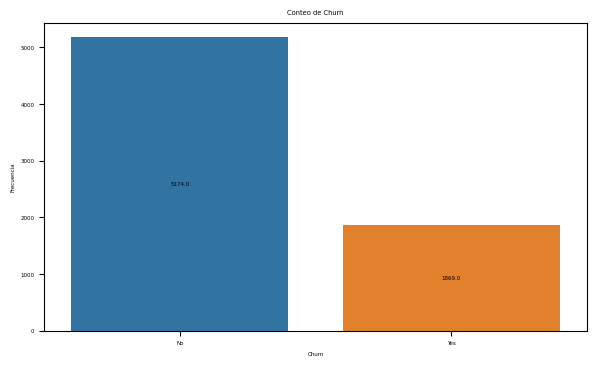

In [77]:
# Se grafica el conteo de categorías en la columna 'Churn'
plt.figure(figsize=(7,4))                                       # Se crea una figura
sns.countplot(data=df, x='Churn')                               # Se grafica el conteo de categorías en la columna 'Churn'
plt.title('Conteo de Churn')                                    # Se agrega el título
plt.xlabel('Churn')                                             # Se agrega la etiqueta del eje x
plt.ylabel('Frecuencia')                                        # Se agrega la etiqueta del eje y

for p in plt.gca().patches:                                     # Se itera sobre las barras para agregar el valor de cada categoría
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2), ha='center', va='center', xytext=(0, 0), textcoords='offset points')

plt.show()                                                      # Se muestra la figura

*Distribución de tenure*

La distribución de la variable **tenure** (número de meses que el cliente ha estado con la empresa) muestra que hay una mayor concentración de clientes en los primeros meses, disminuyendo gradualmente a medida que aumenta el número de meses. Esto sugiere que con el tiempo, algunos clientes pueden abandonar los servicios de la empresa. Cabe destacar que hay una gran cantidad de clientes con una duración de 70 o más meses. Esto obviamente indica que hay clientes que han estado con la empresa durante un largo período de tiempo.

*Distribución de tenure por Churn*

Al analizar la distribución de **tenure** para los clientes que han abandonado los servicios (Churn = Yes) y los que no lo han hecho (Churn = No), se observa que los clientes que han abandonado los servicios tienden a tener una menor duración de contrato en comparación con los que no lo han hecho. Esto sugiere que la mayoría de los clientes que abandonan los servicios lo hacen en los primeros meses de contratación.

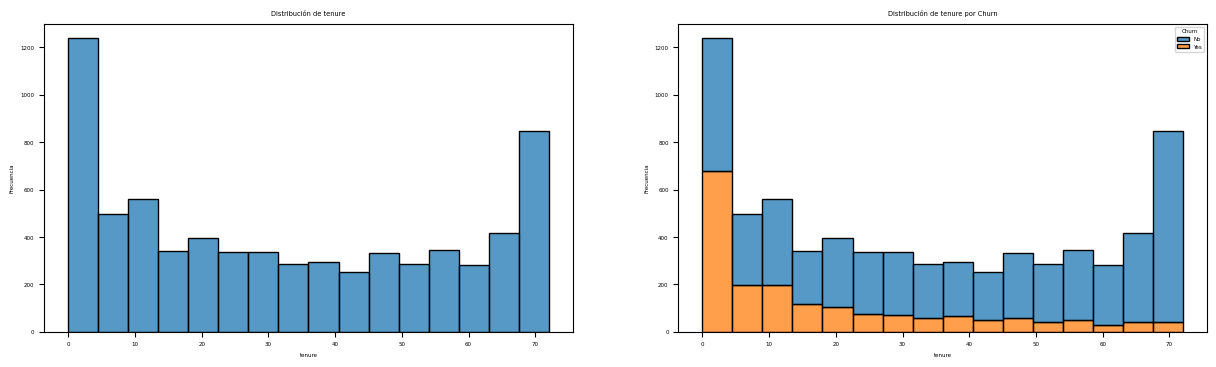

In [78]:
# Se grafica la distribución de la columna 'tenure'
plot_distribution(df, 'tenure', hue='Churn')

*Distribución de MonthlyCharges*

La distribución de la variable **MonthlyCharges** (cantidad mensual que el cliente paga por los servicios) muestra que hay una mayor concentración de clientes en el rango de precios más bajos. Sin embargo, también parece que hay dos distribuciones distintas en los datos, lo que podría indicar diferentes segmentos de clientes. En una, los clientes pagan una cantidad menor (aprox. $50), mientras que en la otra, los clientes pagan una cantidad mayor (aprox. $80).

*Distribución de MonthlyCharges por Churn*

Al analizar la relación entre **MonthlyCharges** y **Churn**, se observa que los clientes que han abandonado los servicios tienden a pagar una cantidad promedio mayor (entre $70 y $100) en comparación con los que no lo han hecho. Esto sugiere que los clientes que pagan más por los servicios son más propensos a abandonarlos, posiblemente debido a la búsqueda de mejores ofertas.

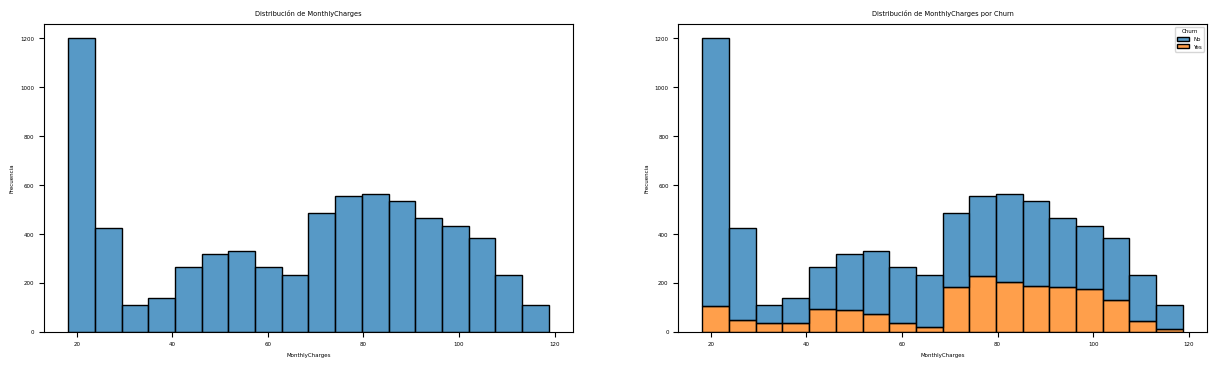

In [79]:
# Se grafica la distribución de la columna 'MonthlyCharges'
plot_distribution(df, 'MonthlyCharges', hue='Churn')

*Distribución de TotalCharges*

La distribución de la variable **TotalCharges** (cantidad total que el cliente ha pagado por los servicios desde que se unió) muestra una concentración de clientes en el rango de precios más bajos. Conforme aumenta el monto total pagado, la cantidad de clientes disminuye, lo que sugiere que hay una gran cantidad de clientes que han pagado una cantidad menor por los servicios.

*Distribución de TotalCharges por Churn*

Al analizar la relación entre **TotalCharges** y **Churn**, se observa que los clientes que han abandonado los servicios tienden a haber pagado una cantidad total menor en comparación con los que no lo han hecho. Esto sugiere que los clientes que abandonan los servicios pueden no haber invertido tanto en la empresa, lo que podría ser un indicador de su propensión a abandonar.

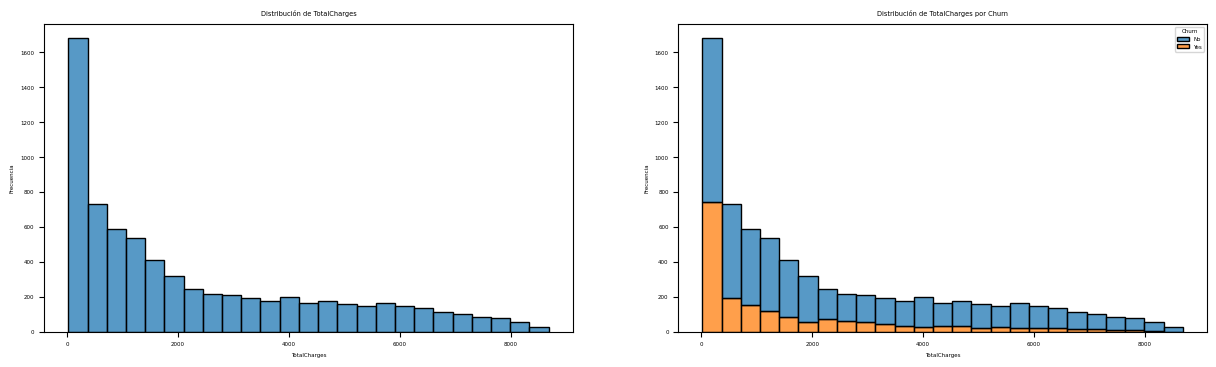

In [80]:
# Se grafica la distribución de la columna 'TotalCharges'
plot_distribution(df, 'TotalCharges', hue='Churn')

*Conteo de Género*

El conteo de género muestra que hay una cantidad similar de clientes hombres y mujeres en el dataset. Esto indica que el dataset está equilibrado en términos de género.

*Conteo de Género por Churn*

Al analizar la relación entre el género y el churn, se observa que no hay una diferencia significativa en la proporción de churn entre hombres y mujeres. Esto sugiere que el género no es un factor determinante en la decisión de los clientes de abandonar los servicios.

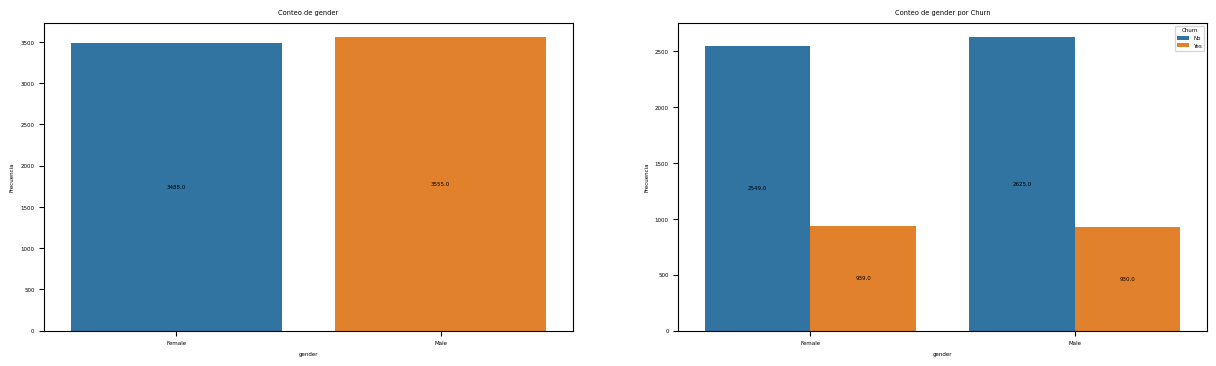

In [81]:
# Se grafica el conteo de categorías en la columna 'gender'
plot_category_count(df, 'gender', 'Churn')               

*Conteo de SeniorCitizen*

El conteo de **SeniorCitizen** muestra que la mayoría de los clientes no son personas mayores. En otras palabras, la mayoría de los clientes son personas menores de 65 años.

*Conteo de SeniorCitizen por Churn*

Al analizar la distribución de **SeniorCitizen** para los clientes que han abandonado los servicios (Churn = Yes) y los que no lo han hecho (Churn = No), se observa que la proporción de personas mayores que han abandonado los servicios es mayor en comparación con las personas menores. 

En realidad, a simple vista, más del 70% de las personas mayores han abandonado los servicios, mientras que menos del 35% de las personas menores lo han hecho. Esto sugiere que la edad puede ser un factor determinante en la decisión de los clientes de abandonar los servicios.

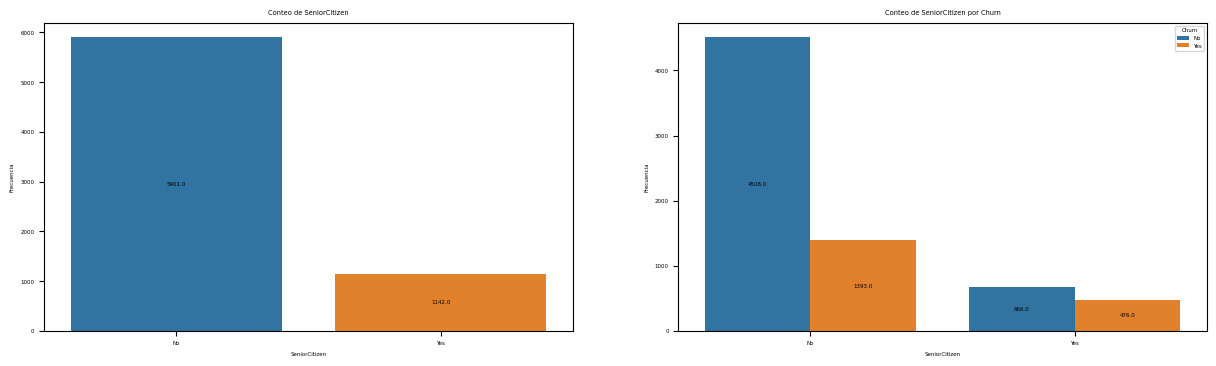

In [82]:
# Se grafica el conteo de categorías en la columna 'SeniorCitizen'
plot_category_count(df, 'SeniorCitizen', 'Churn')

*Conteo de Partner*

En cuanto a la variable **Partner**, se observa que los datos están relativamente equilibrados, con una cantidad similar de clientes que tienen y no tienen pareja. 

*Conteo de Partner por Churn*

Al analizar la relación entre **Partner** y **Churn**, se observa que los clientes que no tienen pareja tienden a abandonar los servicios en una proporción mayor en comparación con los que tienen pareja. Esto posiblemente debido a que los clientes sin pareja pueden tener menos compromiso con la empresa y, por lo tanto, ser más propensos a abandonar los servicios.

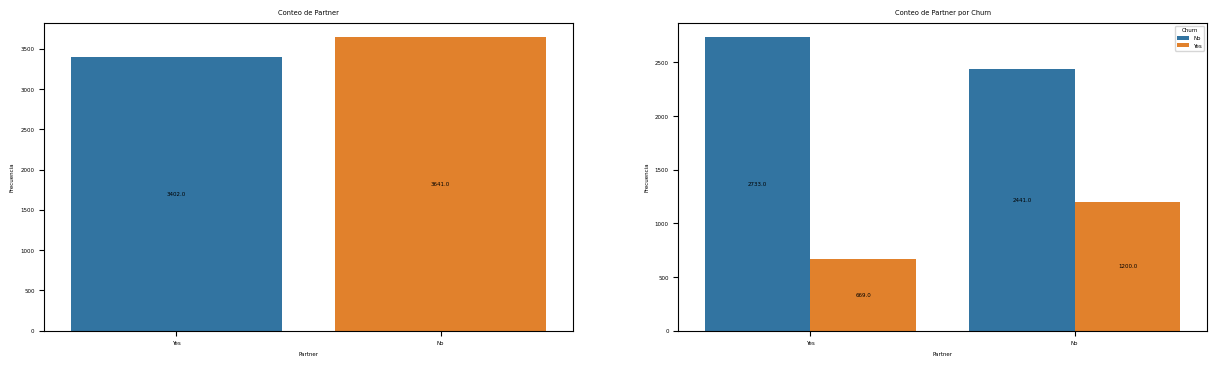

In [83]:
# Se grafica el conteo de categorías en la columna 'Partner'
plot_category_count(df, 'Partner', 'Churn')

*Conteo de Dependents*

En cuanto a la variable **Dependents**, se observa que la mayoría de los clientes no tienen dependientes. Esto sugiere que la mayoría de los clientes son individuos sin responsabilidades familiares.

*Conteo de Dependents por Churn*

Al analizar la relación entre **Dependents** y **Churn**, se observa que los clientes que no tienen dependientes tienden a abandonar los servicios en una proporción mayor en comparación con los que tienen dependientes. Esto posiblemente debido a que no tener dependientes puede hacer que los clientes sean más flexibles en su elección de servicios y, por lo tanto, más propensos a abandonarlos.

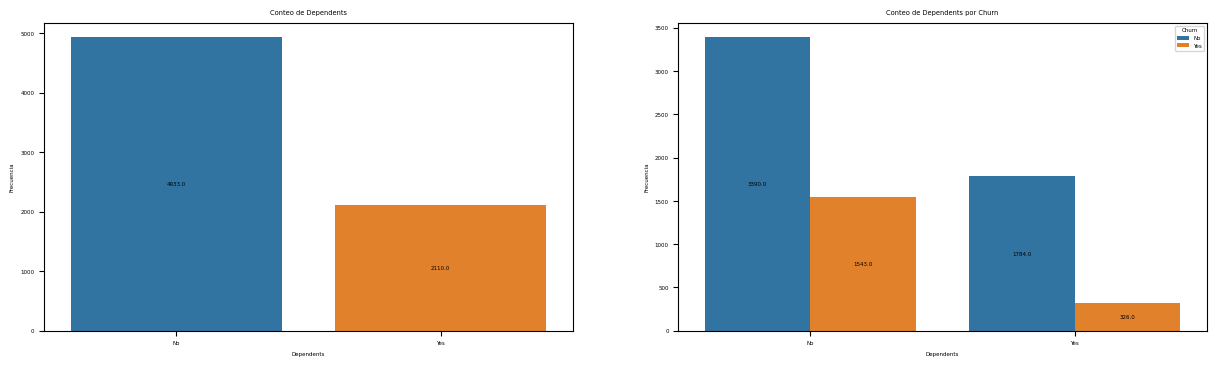

In [84]:
# Se grafica el conteo de categorías en la columna 'Dependents'
plot_category_count(df, 'Dependents', 'Churn')

*Conteo de PhoneService*

En cuanto a la variable **PhoneService**, se observa que la mayoría de los clientes tienen servicio telefónico. Esto sugiere que el servicio telefónico es una característica común entre los clientes.

*Conteo de PhoneService por Churn*

Al analizar la relación entre **PhoneService** y **Churn**, se puede observar que la proporción de clientes que han abandonado los servicios es similar para aquellos que tienen y no tienen servicio telefónico (33% y 36%). Esto sugiere que el servicio telefónico no es un factor determinante en la decisión de los clientes de abandonar los servicios.

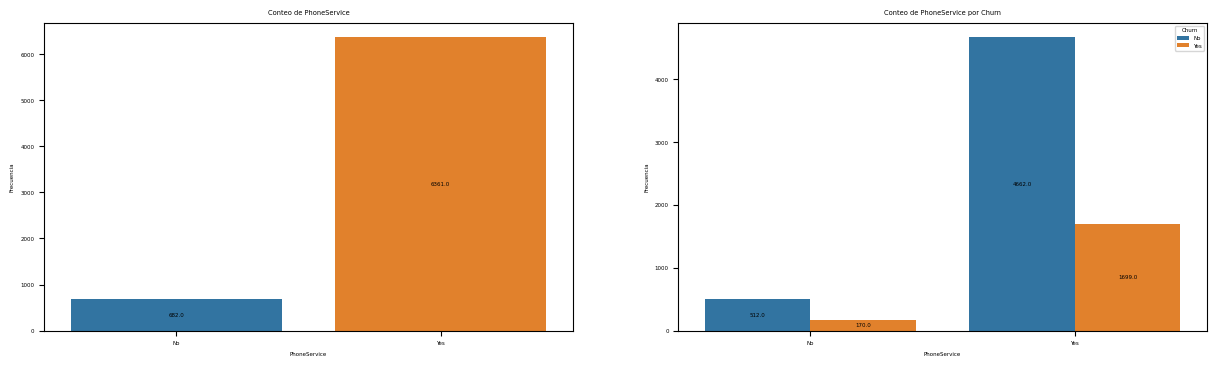

In [85]:
# Se grafica el conteo de categorías en la columna 'PhoneService'
plot_category_count(df, 'PhoneService', 'Churn')

*Conteo de MultipleLines*

En cuanto a la variable **MultipleLines**, se observa que la mayoría de los clientes no tienen múltiples líneas telefónicas. Esto sugiere que la mayoría de los clientes tienen un solo servicio de línea telefónica. Se recomienda analizar posteriormente la relación entre **MultipleLines** y **Dependents** o **Partner** para obtener más información sobre los patrones de uso de los servicios.

*Conteo de MultipleLines por Churn*

Al analizar la relación entre **MultipleLines** y **Churn**, se observa que la proporción de clientes que han abandonado los servicios es relativamente mayor para aquellos que tienen múltiples líneas telefónicas en comparación con los que no las tienen. 

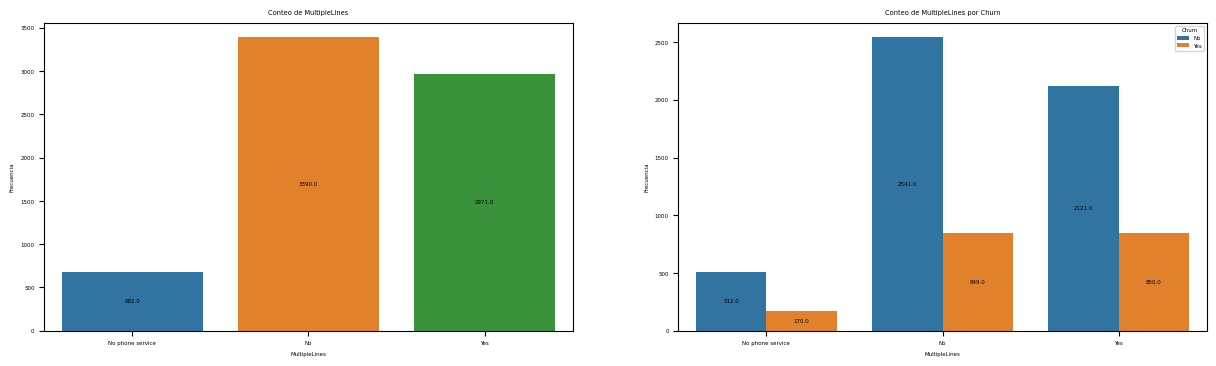

In [86]:
# Se grafica el conteo de categorías en la columna 'MultipleLines'
plot_category_count(df, 'MultipleLines', 'Churn')

*Conteo de InternetService*

En cuanto a la variable **InternetService**, se observa que la mayoría de los clientes tienen servicio de internet. De estos, la mayoría tiene servicio de fibra óptica, seguido por DSL. Cabe destacar que DSL es una tecnología de internet más antigua en comparación con la fibra óptica.

*Conteo de InternetService por Churn*

Al analizar la relación entre **InternetService** y **Churn**, se observa que la proporción de clientes que han abandonado los servicios es mayor para aquellos que tienen servicio de fibra óptica en comparación con los que tienen DSL. Como se mencionó anteriormente, DSL es una tecnología de internet más antigua, por lo que es posible que los clientes con DSL simplemente hayan estado con la empresa por más tiempo y, por lo tanto, sean menos propensos a abandonar los servicios.

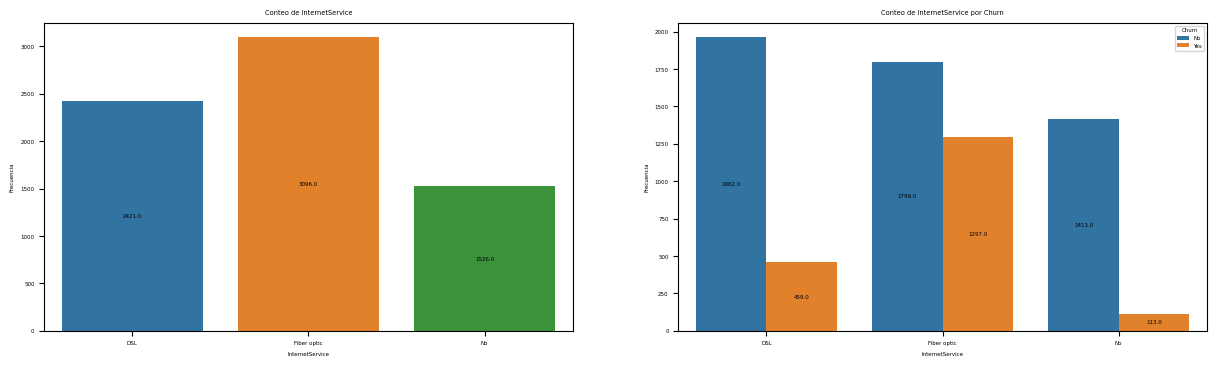

In [87]:
# Se grafica el conteo de categorías en la columna 'InternetService'
plot_category_count(df, 'InternetService', 'Churn')

*Conteo de Servicios Adicionales*

En cuanto a las variables que representan servicios adicionales, como **OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV** y **StreamingMovies**, se observa un balance entre los clientes que tienen y no tienen estos servicios. Esto sugiere que estos servicios son comunes entre los clientes.

Sin embargo, al analizar el Churn por estos servicios, se observa que los clientes que no tienen servicios adicionales, como **OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV** y **StreamingMovies**, tienden a abandonar los servicios en una proporción mayor en comparación con los que sí los tienen. Esto posiblemente debido a que los servicios adicionales pueden mejorar la experiencia del cliente y, por lo tanto, reducir la probabilidad de abandono.

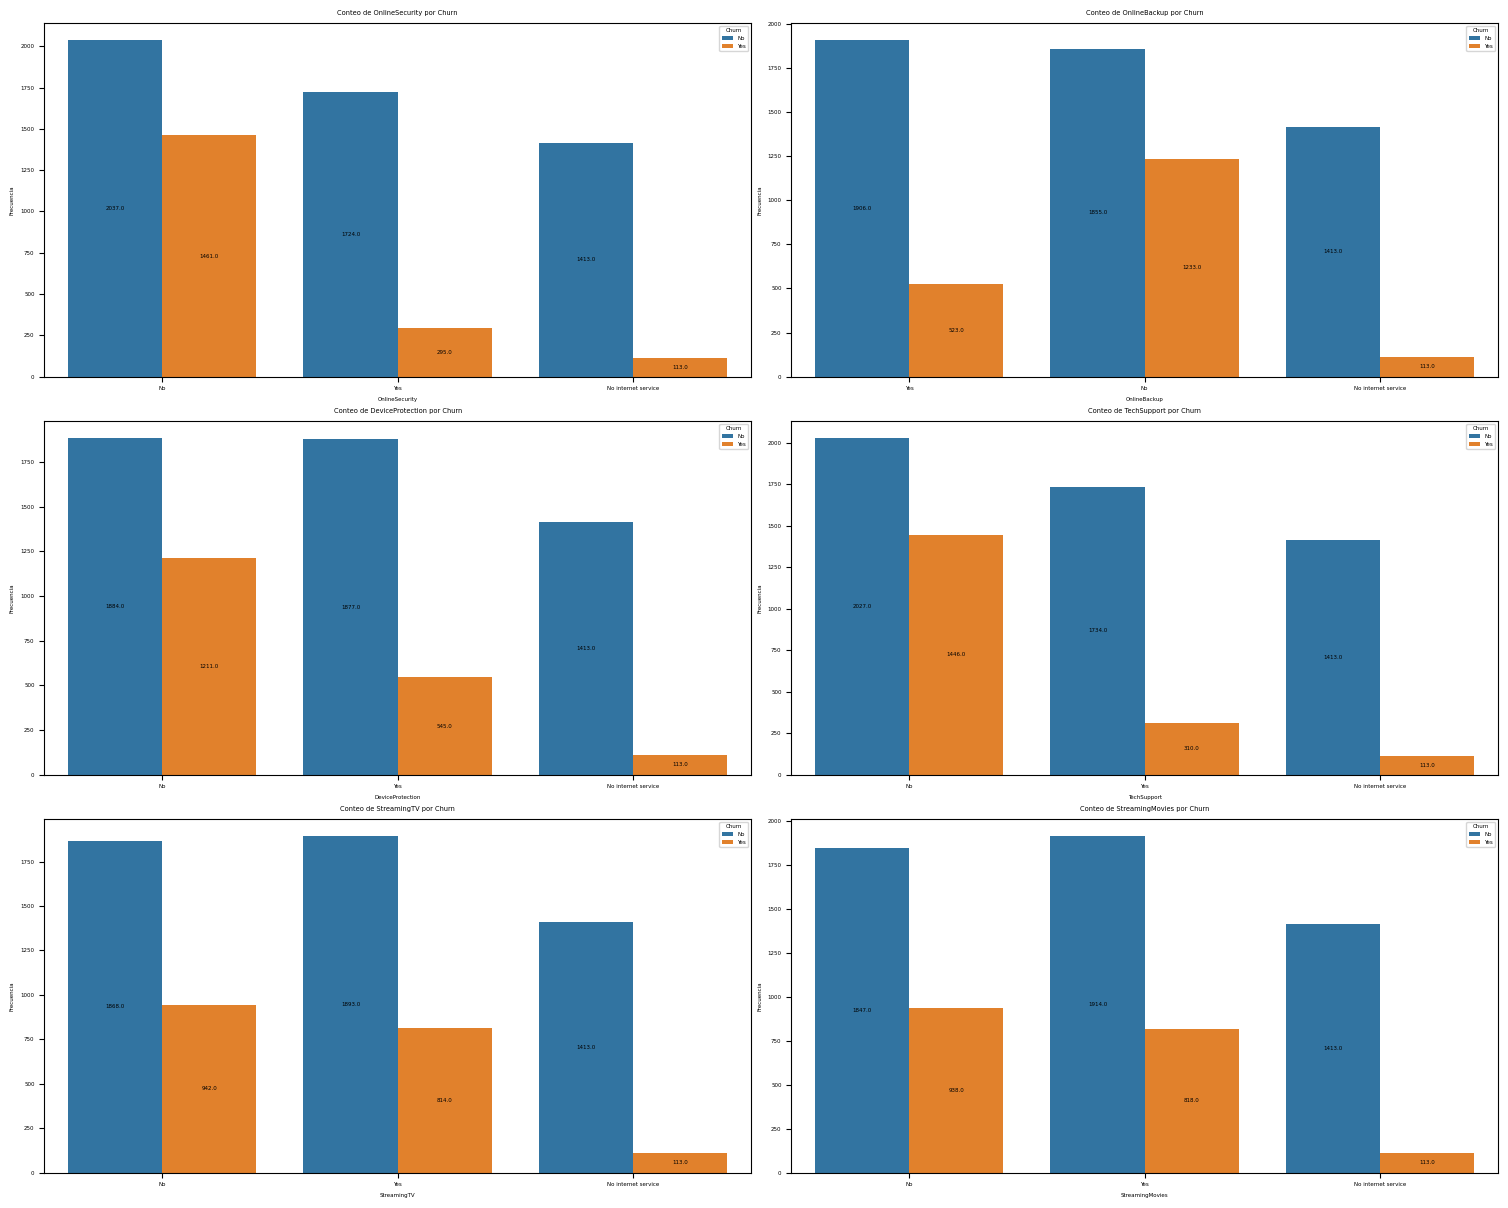

In [88]:
# Se grafica el conteo de categorías en las columnas 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' y 'StreamingMovies'
multi_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
plot_multi_category_count(df, multi_cols, 'Churn')

*Conteo de Contratos*

En cuanto a la variable **Contract**, se observa que la mayoría de los clientes tienen contratos mensuales. Sin embargo, también hay una cantidad significativa de clientes con contratos de un año y dos años. 

*Conteo de Contratos por Churn*

Al analizar la relación entre **Contract** y **Churn**, se observa que la proporción de clientes que han abandonado los servicios es mayor para aquellos con contratos mensuales en comparación con los que tienen contratos de un año y dos años. Esto posiblemente debido a que los clientes con contratos mensuales tienen menos compromiso con la empresa ya que pueden cancelar en cualquier momento.

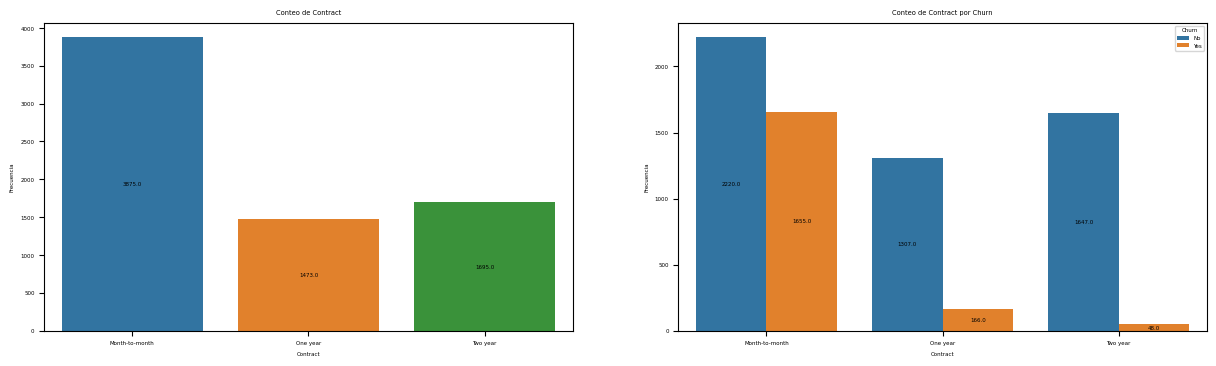

In [89]:
# Se grafica el conteo de categorías en la columna 'Contract'
plot_category_count(df, 'Contract', 'Churn') 

*Conteo de Facturación Electrónica*

En cuanto a la variable **PaperlessBilling**, se observa que la mayoría de los clientes utilizan facturación electrónica. Sin embargo, también hay una cantidad significativa de clientes que no utilizan este servicio. Estos clientes pueden que sean adultos más tradicionales que prefieren la facturación en papel.

*Conteo de Facturación Electrónica por Churn*

Al analizar la relación entre **PaperlessBilling** y **Churn**, se observa que la proporción de clientes que han abandonado los servicios es mayor para aquellos que utilizan facturación electrónica en comparación con los que no lo hacen. 

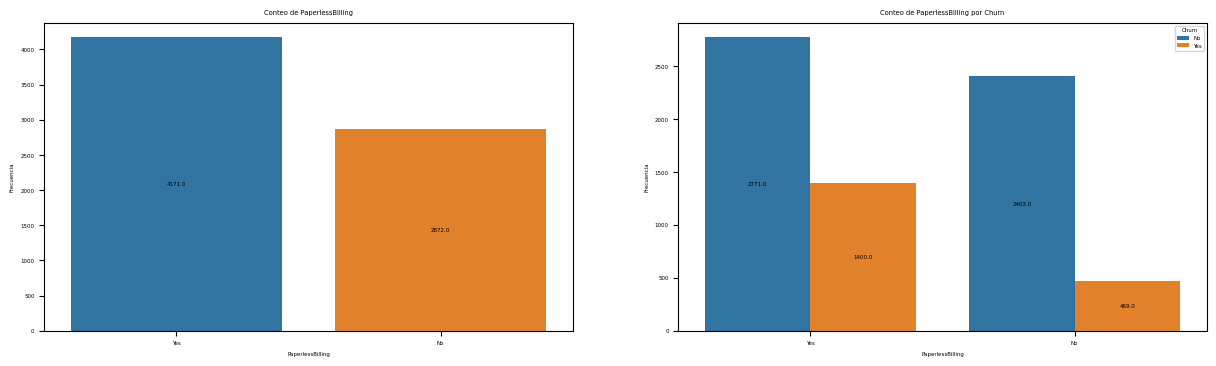

In [90]:
# Se grafica el conteo de categorías en la columna 'PaperlessBilling'
plot_category_count(df, 'PaperlessBilling', 'Churn')

*Conteo de Métodos de Pago*

En cuanto a la variable **PaymentMethod**, se observa que electronic check es el método de pago más común entre los clientes. Sin embargo, bank transfer (automatic), credit card (automatic) y electronic check son métodos bastante balanceados en términos de uso. 

*Conteo de Métodos de Pago por Churn*

Anteriormente se mencionó que bank transfer (automatic), credit card (automatic) y electronic check son métodos de pago bastante balanceados en términos de uso. Este patrón se mantiene al analizar la relación entre **PaymentMethod** y **Churn**, lo que sugiere que el método de pago no es un factor determinante en la decisión de los clientes de abandonar los servicios. Sin embargo, para electronic check, se observa que casi la mitad de los clientes que han abandonado los servicios utilizan este método de pago. Por lo tanto, este método de pago sí podría afectar la propensión de los clientes a abandonar los servicios.

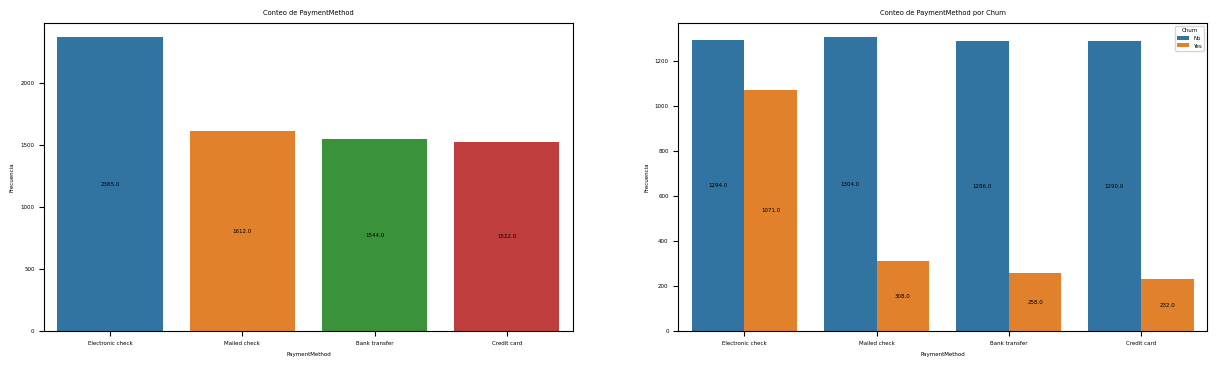

In [91]:
# Se grafica el conteo de categorías en la columna 'PaymentMethod'
plot_category_count(df, 'PaymentMethod', 'Churn')

*Pagos Mensuales Promedio vs. Churn*

El gráfico de barras muestra el promedio de pagos mensuales para los clientes que han abandonado los servicios (Churn = Yes) y los que no lo han hecho (Churn = No). Se observa que los clientes que han abandonado los servicios tienden a pagar una cantidad mensual mayor en comparación con los que no lo han hecho. Esto sugiere que los clientes que pagan más por los servicios son más propensos a abandonarlos.

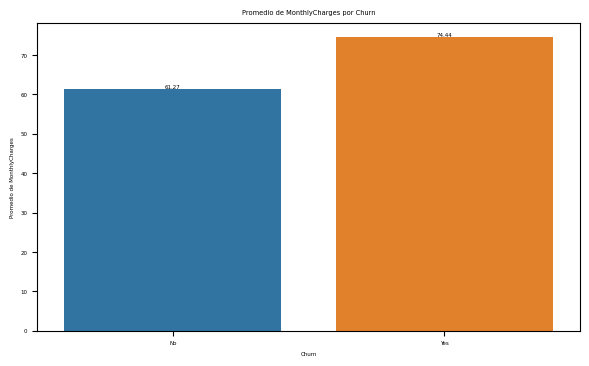

In [92]:
# Pagos mensuales promedio por Churn
avg_monthly_charges = df.groupby('Churn')['MonthlyCharges'].mean()          # Se agrupa por 'Churn' y se calcula el promedio de 'MonthlyCharges'

plt.figure(figsize=(7,4))                                                   # Se crea una figura
sns.barplot(x=avg_monthly_charges.index, y=avg_monthly_charges.values)      # Se grafica el promedio de 'MonthlyCharges' por 'Churn'
plt.title('Promedio de MonthlyCharges por Churn')                           # Se agrega el título
plt.xlabel('Churn')                                                         # Se agrega la etiqueta del eje x
plt.ylabel('Promedio de MonthlyCharges')                                    # Se agrega la etiqueta del eje y

for i, v in enumerate(avg_monthly_charges.values):                          # Se itera sobre los valores para agregar el valor a cada barra
    plt.text(i, v, round(v, 2), ha='center', va='bottom')

plt.show()                                                                  # Se muestra la figura


*Pagos Totales Promedio vs. Churn*

El gráfico de barras muestra el promedio de pagos totales para los clientes que han abandonado los servicios (Churn = Yes) y los que no lo han hecho (Churn = No). Se observa que los clientes que han abandonado los servicios tienden a haber pagado una cantidad total menor en comparación con los que no lo han hecho. Esto sugiere que los clientes que abandonan los servicios pueden no haber invertido tanto en la empresa, lo que podría ser un indicador de su propensión a abandonar.

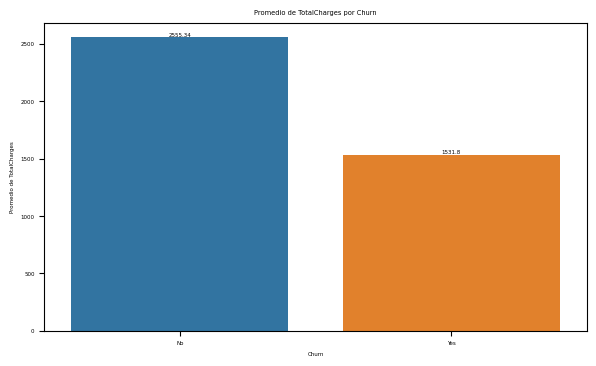

In [93]:
# Pagos totales promedio por Churn
avg_total_charges = df.groupby('Churn')['TotalCharges'].mean()              # Se agrupa por 'Churn' y se calcula el promedio de 'TotalCharges'

plt.figure(figsize=(7,4))                                                   # Se crea una figura
sns.barplot(x=avg_total_charges.index, y=avg_total_charges.values)          # Se grafica el promedio de 'TotalCharges' por 'Churn'
plt.title('Promedio de TotalCharges por Churn')                             # Se agrega el título
plt.xlabel('Churn')                                                         # Se agrega la etiqueta del eje x
plt.ylabel('Promedio de TotalCharges')                                      # Se agrega la etiqueta del eje y

for i, v in enumerate(avg_total_charges.values):                            # Se itera sobre los valores para agregar el valor a cada barra
    plt.text(i, v, round(v, 2), ha='center', va='bottom')

plt.show()                                                                  # Se muestra la figura

##### *2.4. Pre-Procesamiento de Datos*

El último paso del EDA consiste en determinar la correlación entre las variables. Sin embargo, debido a que el dataset contiene variables categóricas, se debe realizar un pre-procesamiento de los datos antes de calcular la correlación. Asimismo, se aprovechó para realizar la imputación de los valores faltantes en la columna **TotalCharges**.



Anteriormente se identificó que la columna **TotalCharges** tiene 11 valores nulos. Para abordar este problema, se procede a reemplazar los valores nulos con la mediana de la columna. 

In [94]:
# Procesamiento de Datos Nulos

# Remplazar valores nulos en 'TotalCharges' con la media
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Verificar que no haya valores nulos
print('Valores nulos por columna:')             # Se imprime el mensaje
print(df.isnull().sum())                        # Se cuentan los valores nulos por columna

Valores nulos por columna:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Además, se procede a realizar el encoding de las variables categóricas para poder utilizarlas en los modelos de machine learning. Se opta por eliminar la variable de CustomerID del dataset ya que no aporta información relevante para la predicción de churn.

In [95]:
# Preprocesamiento de Datos

# Eliminación de columnas innecesarias
df = df.drop(columns=['customerID'])                        # Se eliminan las columnas 'customerID'

# Encoding de columnas categóricas (Dummies)
df = pd.get_dummies(df, drop_first=True)                    # Se convierten las columnas categóricas a dummies
df.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)     # Se renombra la columna 'Churn_Yes' a 'Churn'

# Cambiar True por 1 y False por 0 en todas las columnas
df = df.replace({True: 1, False: 0})

df.head()                                                   # Se visualizan los primeros registros


,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,29.85,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,2,53.85,108.15,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


##### *2.5. Correlación*

Con las variables codificadas, se procede a realizar una matriz de correlación para identificar posibles relaciones entre las variables y el churn de clientes

Esta fase es sumamente importante para identificar posibles relaciones entre las variables y el churn de clientes. A través de esto, se puede identificar qué variables tienen una mayor influencia en la predicción de churn y cuáles pueden ser descartadas por tener una baja correlación.



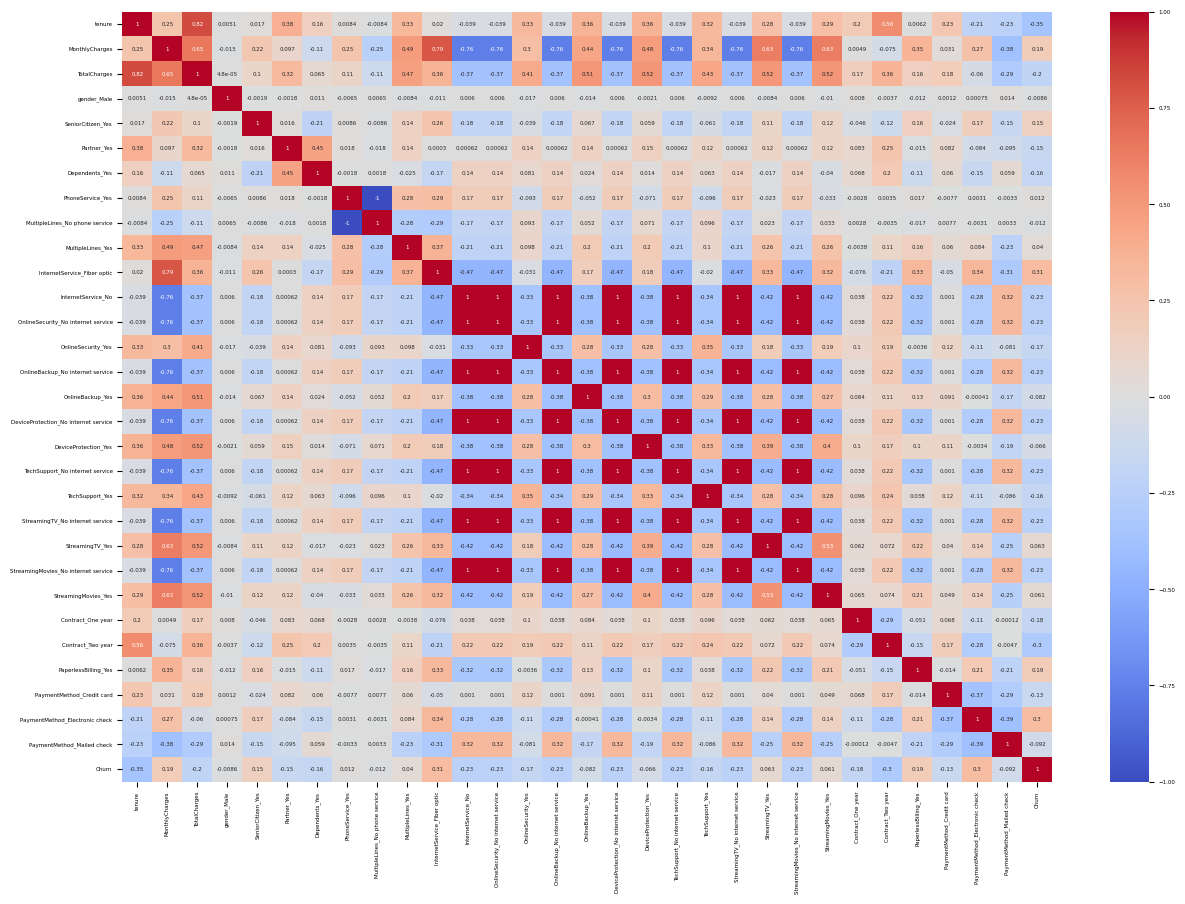

In [96]:
# Matriz de correlación
corr = df.corr()                                            # Se calcula la matriz de correlación
plt.figure(figsize=(15, 10))                                # Se crea una figura
sns.heatmap(corr, annot=True, cmap='coolwarm')              # Se grafica la matriz de correlación
plt.rc('font', size=4)                                      # Se cambia el tamaño de la fuente

plt.show()                                                  # Se muestra la figura

Como se pudo observar, hay una gran cantidad de variables en la matriz. Esto ocasiona que sea difícil identificar las correlaciones más importantes. Por lo tanto, se procede a imprimir las correlaciones de las variables con la variable **Churn** para identificar las relaciones más significativas.

In [97]:
# Identificar las variables más correlacionadas con 'Churn'
corr_churn = corr['Churn']                                          # Se obtiene la correlación con 'Churn'
corr_churn = corr_churn.abs().sort_values(ascending=False)          # Se ordenan los valores de forma descendente en valores absolutos

print(corr_churn)                                                   # Se imprime la correlación con 'Churn'

Churn                                   1.000000
tenure                                  0.352229
InternetService_Fiber optic             0.308020
Contract_Two year                       0.302253
PaymentMethod_Electronic check          0.301919
DeviceProtection_No internet service    0.227890
OnlineSecurity_No internet service      0.227890
StreamingMovies_No internet service     0.227890
StreamingTV_No internet service         0.227890
TechSupport_No internet service         0.227890
OnlineBackup_No internet service        0.227890
InternetService_No                      0.227890
TotalCharges                            0.199428
MonthlyCharges                          0.193356
PaperlessBilling_Yes                    0.191825
Contract_One year                       0.177820
OnlineSecurity_Yes                      0.171226
TechSupport_Yes                         0.164674
Dependents_Yes                          0.164221
SeniorCitizen_Yes                       0.150889
Partner_Yes         

Según el listado impreso, hay varias variables con muy baja correlación con **Churn**. Esto sugiere que estas variables pueden no ser muy relevantes para predecir el abandono de los servicios. Por otro lado, a continuación se procede con la eliminación de las variables con baja correlación para simplificar el análisis.

In [98]:
# Eliminar columnas con baja correlación (menor a 0.15)
low_corr_cols = corr_churn[corr_churn < 0.15].index             # Se obtienen las columnas con correlación menor a 0.15
df = df.drop(columns=low_corr_cols)                             # Se eliminan las columnas con baja correlación

df.head()                                                       # Se visualizan los primeros registros

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,DeviceProtection_No internet service,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,Churn
0,1,29.85,29.85,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,34,56.95,1889.50,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,53.85,108.15,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,45,42.30,1840.75,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
4,2,70.70,151.65,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,1


##### *2.6. Conclusiones*

El análisis revela varios factores que parecen estar correlacionados con la propensión de los clientes a abandonar los servicios (churn). La duración del contrato (tenure) muestra una fuerte correlación negativa con el churn, sugiriendo que los clientes que permanecen más tiempo con la empresa son menos propensos a abandonar. El tipo de servicio de internet, específicamente la fibra óptica, está correlacionado con el churn, lo que podría indicar problemas de satisfacción o precios más altos asociados con este servicio. Los contratos a largo plazo (especialmente los de dos años) están correlacionados con el churn, lo que implica que los compromisos a largo plazo reducen la probabilidad de abandono.

Otros factores que muestran una correlación significativa con el churn incluyen el método de pago electrónico, la facturación sin papel, y la falta de servicios adicionales como seguridad en línea o soporte técnico. Curiosamente, los cargos mensuales más altos están asociados con una mayor probabilidad de abandono, mientras que los cargos totales más altos están asociados con una menor probabilidad. Esto podría sugerir que los clientes que han invertido más en total en los servicios de la empresa son menos propensos a abandonar, pero aquellos que pagan más mensualmente podrían estar buscando alternativas más económicas.

Es importante notar que factores demográficos como el género tienen poca correlación con el churn, mientras que ser ciudadano senior muestra una correlación moderada. La presencia de dependientes o pareja está levemente correlacionada con el churn, lo que podría indicar que los clientes con responsabilidades familiares son más estables. En general, estos hallazgos sugieren que las estrategias para reducir el churn podrían enfocarse en mejorar la satisfacción con los servicios de fibra óptica, ofrecer incentivos para contratos a largo plazo, y proporcionar servicios adicionales que aumenten el valor percibido por el cliente.


-------

#### *3. Modelos de Predicción*

Con el EDA completado, se procede a la implementación de modelos de predicción para predecir el churn de clientes. En este caso, se utilizarán árboles de decisión y Random Forest para predecir el churn de clientes.

##### *3.1. Dividir los datos en conjuntos de entrenamiento y prueba*

Como primer punto, se procede a dividir los datos en conjuntos de entrenamiento y prueba para poder entrenar y evaluar los modelos de predicción. Asimismo, se normalizan los datos para mejorar el rendimiento de los modelos.

In [99]:
# Separar las características y la variable objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### *3.2. Entrenamiento de Modelos*

A continuación, se procede a entrenar los modelos de predicción de churn utilizando árboles de decisión y Random Forest.


**Árbol de Decisión**

El primer modelo de predicción implementado es un árbol de decisión. Se utilizó la implementación de scikit-learn para entrenar el modelo y predecir el churn de clientes.

In [100]:
# ------ GridSearchCV ------

# Parámetros a evaluar
param_grid = {
    'criterion': ['gini', 'entropy'],               # Criterio para medir la calidad de la división
    'splitter': ['best', 'random'],                 # Estrategia utilizada para dividir en cada nodo
    'max_depth': [10, 20],                          # Profundidad máxima del árbol
    'min_samples_split': [2, 5],                    # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [5, 10],                    # Número mínimo de muestras necesarias en un nodo hoja
    'max_features': ['sqrt', 'log2']                # Número de características a considerar al buscar la mejor división
}

# Se crea un modelo de árbol de decisión y se realiza la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el puntaje
print("Mejores parámetros después de GridSearchCV:", grid_search.best_params_)
print("Mejor puntaje de precisión después de GridSearchCV:", grid_search.best_score_)

# Usar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Reporte de clasificación, matriz de confusión y exactitud
print("Reporte de Clasificación del Mejor Modelo del Árbol de Decisión:")
print(classification_report(y_test, y_pred_best))
print("Matriz de Confusión del Mejor Modelo:")
print(confusion_matrix(y_test, y_pred_best))
print("Exactitud del Mejor Modelo:", accuracy_score(y_test, y_pred_best))


Mejores parámetros después de GridSearchCV: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Mejor puntaje de precisión después de GridSearchCV: 0.7894907967048123
Reporte de Clasificación del Mejor Modelo del Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1036
           1       0.63      0.55      0.59       373

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409

Matriz de Confusión del Mejor Modelo:
[[912 124]
 [166 207]]
Exactitud del Mejor Modelo: 0.794180269694819


Shap no funciona bien con GridSearchCV, por lo que se procede a entrenar el modelo DecisionTreeClassifier sin GridSearchCV.

In [101]:
# Mejores parámetros después de GridSearchCV
best_params = {
    'criterion': 'gini',           
    'splitter': 'best',            
    'max_depth': 10,               
    'min_samples_split': 5,        
    'min_samples_leaf': 5,         
    'max_features': 'sqrt'         
}

# Se define el modelo de Árbol de Decisión con los mejores parámetros
best_model = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    splitter=best_params['splitter'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_best = best_model.predict(X_test)

# Reporte de clasificación, matriz de confusión y exactitud
print("Reporte de Clasificación del Mejor Modelo del Árbol de Decisión:")
print(classification_report(y_test, y_pred_best))
print("Matriz de Confusión del Mejor Modelo:")
print(confusion_matrix(y_test, y_pred_best))
print("Exactitud del Mejor Modelo:", accuracy_score(y_test, y_pred_best))

Reporte de Clasificación del Mejor Modelo del Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1036
           1       0.61      0.52      0.56       373

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409

Matriz de Confusión del Mejor Modelo:
[[912 124]
 [179 194]]
Exactitud del Mejor Modelo: 0.7849538679914834


**Random Forest**

Como segundo modelo de predicción, se implementa un Random Forest. Nuevamente, se utilizó la implementación de scikit-learn para entrenar el modelo y predecir el churn de clientes.

In [102]:
# ------ GridSearchCV ------

# Parámetros a evaluar
param_grid_rf = {
    'n_estimators': [100, 200],                 # Número de árboles en el bosque
    'max_depth': [10, 20],                      # Profundidad máxima del árbol
    'min_samples_split': [10, 20],              # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 5],                 # Número mínimo de muestras necesarias en un nodo hoja
    'bootstrap': [True, False]                  # Método de muestreo para construir árboles
}

# Se crea un modelo de random forest y se realiza la búsqueda de hiperparámetros
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf,cv=5,scoring='accuracy')

# Ejecutar la búsqueda de hiperparámetros
grid_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros y el puntaje
print("Mejores parámetros después de GridSearchCV para Random Forest:", grid_search_rf.best_params_)
print("Mejor puntaje de precisión después de GridSearchCV para Random Forest:", grid_search_rf.best_score_)

# Usar el mejor modelo
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Reporte de clasificación, matriz de confusión y exactitud
print("Reporte de Clasificación del Mejor Modelo de Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Matriz de Confusión del Mejor Modelo de Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("Exactitud del Mejor Modelo de Random Forest:", accuracy_score(y_test, y_pred_rf))


Mejores parámetros después de GridSearchCV para Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}
Mejor puntaje de precisión después de GridSearchCV para Random Forest: 0.8036906167208562
Reporte de Clasificación del Mejor Modelo de Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.81      1409

Matriz de Confusión del Mejor Modelo de Random Forest:
[[949  87]
 [175 198]]
Exactitud del Mejor Modelo de Random Forest: 0.8140525195173882


Shap no funciona bien con GridSearchCV, por lo que se procede a entrenar el modelo Random Forest sin GridSearchCV.

In [103]:
# Se define el modelo de Random Forest con los mejores parámetros
best_rf_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=20,
    n_estimators=200,
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
best_rf_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = best_rf_model.predict(X_test)

# Reporte de clasificación, matriz de confusión y exactitud
print("Reporte de Clasificación del Modelo de Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Matriz de Confusión del Modelo de Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("Exactitud del Modelo de Random Forest:", accuracy_score(y_test, y_pred_rf))

Reporte de Clasificación del Modelo de Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.81      1409

Matriz de Confusión del Modelo de Random Forest:
[[949  87]
 [175 198]]
Exactitud del Modelo de Random Forest: 0.8140525195173882


#### *4. Analisis SHAP*

##### Inicializar SHAP

In [142]:
shap.initjs()

explainer_dt = shap.Explainer(best_model)
explainer_rf = shap.Explainer(best_rf_model)

In [143]:
shap_values_dt = explainer_dt(X_test)
shap_values_rf = explainer_rf(X_test)

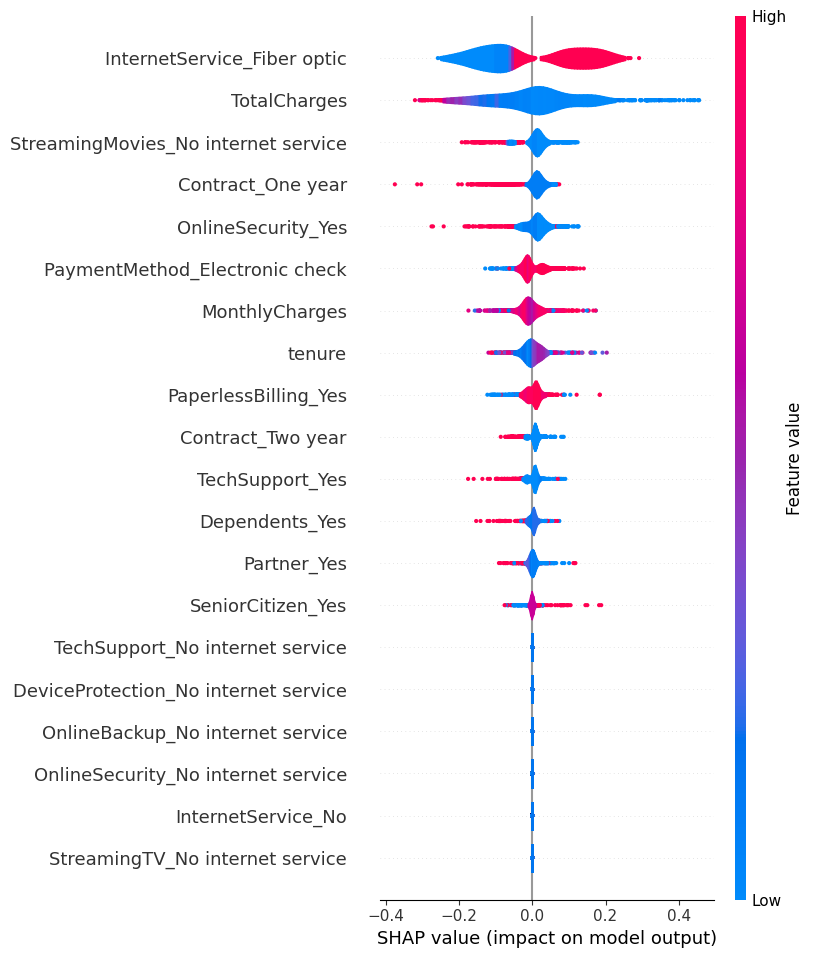

In [144]:
shap.summary_plot(shap_values_dt[:, :, 1], X_test, plot_type='violin')

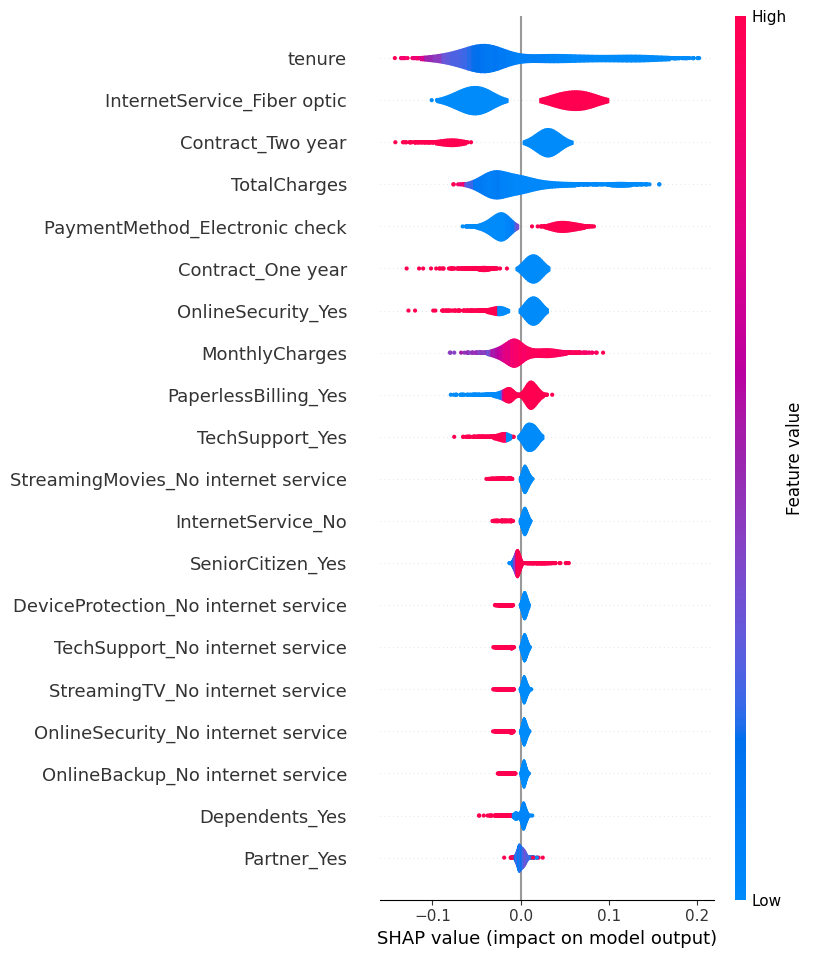

In [145]:
shap.summary_plot(shap_values_rf[:, :, 1], X_test, plot_type='violin')

IndexError: tuple index out of range

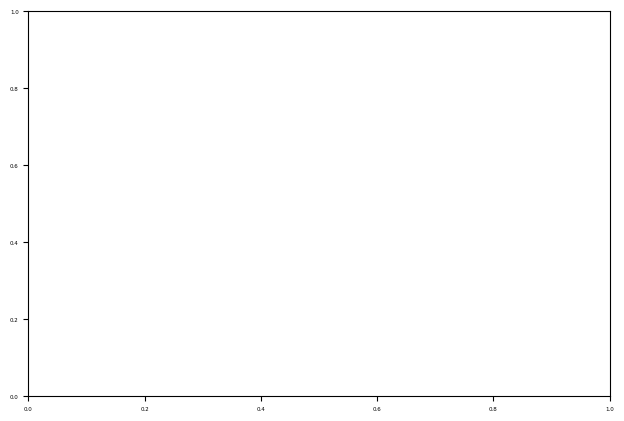

In [161]:
shap.dependence_plot('tenure', shap_values_dt[:, :, 1], X_test, interaction_index='MonthlyCharges')

In [131]:
shap.force_plot(explainer_dt.expected_value[0], shap_values_dt[0, :, 1][0, :], X_test.iloc[0, :])

IndexError: tuple index out of range